In [1]:
import os
import os.path as osp
import sys
sys.path.insert(0, osp.dirname(osp.abspath('.')))

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision.transforms as T

from data.dataset.motsequence import MOTDSequence
from utils.display import draw_box, draw_text
from utils.flow import torchflow2img

## Load target sequence

In [3]:
SEQUENCE = "/home/johnnylord/dataset/NTU-MOTD/test/3p_da_pm_pp.msv"

In [4]:
sequence = MOTDSequence(root=SEQUENCE, mode='test', detector='default-processed-market1501')

In [5]:
print(sequence)

[Sequence]
 - name: 3p_da_pm_pp.msv
 - fps: 30
 - width: 1920
 - height: 1080
 - length: 655
 - detector: default-processed-market1501
 - min_visibility: 0.5
 - min_conf_threshold: 0.0



## Analysis specific frame information

In [6]:
FRAME_ID = 200

In [7]:
inverse = T.ToPILImage()

In [8]:
img, depthmap, flowmap, tboxes, bboxes = sequence[FRAME_ID]

print("IMAGE:", img.shape)
print("DEPTH:", depthmap.shape)
print("FLOW:", flowmap.shape)
print("BBOX:", len(bboxes))

IMAGE: torch.Size([3, 1080, 1920])
DEPTH: torch.Size([3, 1080, 1920])
FLOW: torch.Size([1080, 1920, 2])
BBOX: 3


### Visualize information

In [9]:
TARGET = 2

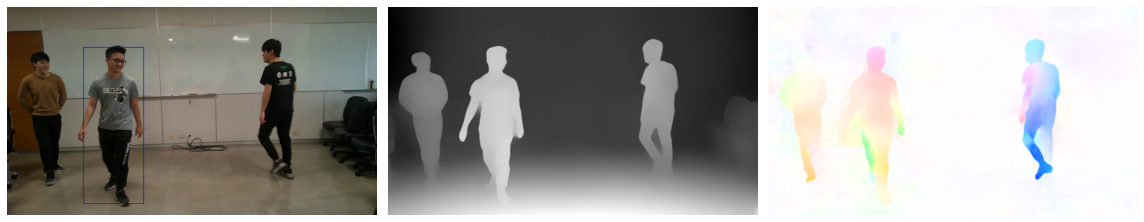

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 4))

# Draw bounding boxes on RGB frame
frame = np.array(inverse(img))
xmin, ymin, width, height = bboxes[TARGET][1:1+4]
xmax = xmin + width
ymax = ymin + height
box = [ xmin, ymin, xmax, ymax ]
draw_box(frame, box)

# Visualize frames
axes[0].imshow(frame)
axes[1].imshow(np.array(inverse(depthmap)))
axes[2].imshow(torchflow2img(flowmap))

axes[0].set_axis_off()
axes[1].set_axis_off()
axes[2].set_axis_off()

plt.tight_layout()

In [11]:
def sample_mean(dist, win_size=5, rounds=1500):
    """Return the sampled mean from the distribution
    
    Args:
        dist (ndarray): data distribution
        win_size (int): size of sampling window
        rounds (int): number of samplings
    """
    means = []
    for i in range(rounds):
        samples = np.random.choice(dist, size=win_size, replace=True)
        means.append(samples.mean())
    return means, np.array(means).mean()

## Sample depth information from the box

In [12]:
# Raw depth distribution
depth_dist = depthmap[TARGET, int(box[1]):int(box[3]), int(box[0]+box[2])//2]
depth_dist = depth_dist.numpy().reshape(-1)

# Median filtered depth distribution (We what to filter out pixel close to us)
means, depth = sample_mean(depth_dist, rounds=300)
print(depth)

0.77341175


## Sample motion information from the box

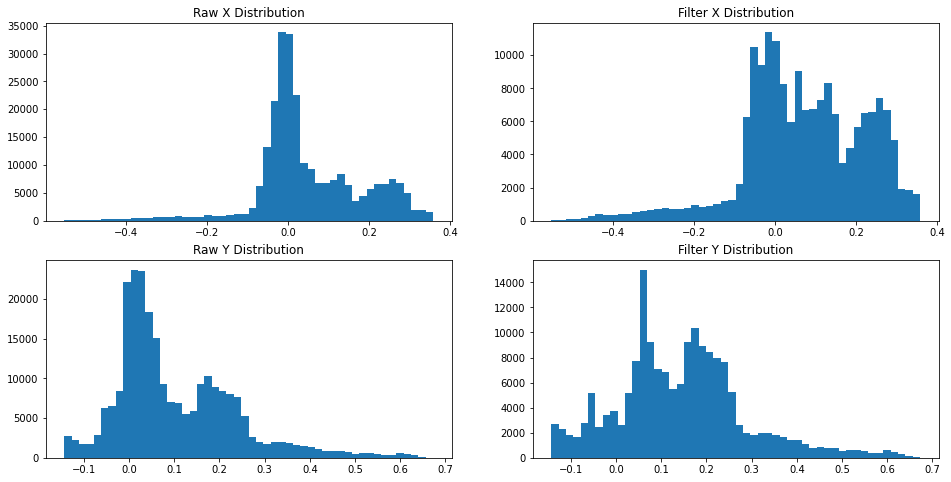

In [13]:
# Raw depth distribution
x_dist = flowmap[int(box[1]):int(box[3]), int(box[0]):int(box[2]), 0].numpy().reshape(-1)
y_dist = flowmap[int(box[1]):int(box[3]), int(box[0]):int(box[2]), 1].numpy().reshape(-1)

# Median filtered depth distribution (We what to filter out pixel has motion)
condition = np.where((
    (x_dist > 0.05)
    |(x_dist < -0.05)
    |(y_dist > 0.05)
    |(y_dist < -0.05)
    ))
x_filter_dist = x_dist[condition]
y_filter_dist = y_dist[condition]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 8))
axes[0][0].set_title("Raw X Distribution")
axes[0][0].hist(x_dist, bins=50);
axes[0][1].set_title("Filter X Distribution")
axes[0][1].hist(x_filter_dist, bins=50);

axes[1][0].set_title("Raw Y Distribution")
axes[1][0].hist(y_dist, bins=50);
axes[1][1].set_title("Filter Y Distribution")
axes[1][1].hist(y_filter_dist, bins=50);

### Sample mean of XY direction

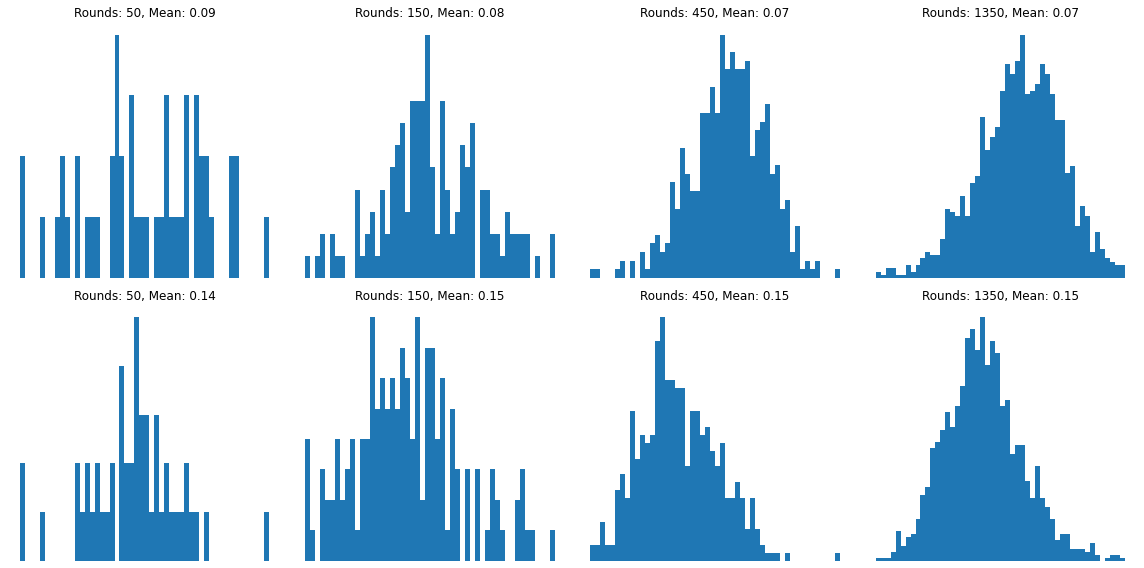

In [14]:
rounds = [ 50, 150, 450, 1350 ]

x_dists = []
x_means = []
for round_ in rounds:
    dist, mean = sample_mean(x_filter_dist, rounds=round_)
    x_dists.append(dist)
    x_means.append(mean)
    
y_dists = []
y_means = []
for round_ in rounds:
    dist, mean = sample_mean(y_filter_dist, rounds=round_)
    y_dists.append(dist)
    y_means.append(mean)
    
fig, axes = plt.subplots(nrows=2, ncols=len(rounds), figsize=(16, 8))
for axe, dist, mean, round_ in zip(axes[0], x_dists, x_means, rounds):
    axe.hist(dist, bins=50)
    axe.set_title(f"Rounds: {round_}, Mean: {mean:.2f}")
    axe.set_axis_off()
    
for axe, dist, mean, round_ in zip(axes[1], y_dists, y_means, rounds):
    axe.hist(dist, bins=50)
    axe.set_title(f"Rounds: {round_}, Mean: {mean:.2f}")
    axe.set_axis_off()

plt.tight_layout()

## Visualize detection in 3D space 

In [15]:
%matplotlib notebook
from matplotlib.animation import FuncAnimation

<IPython.core.display.Javascript object>


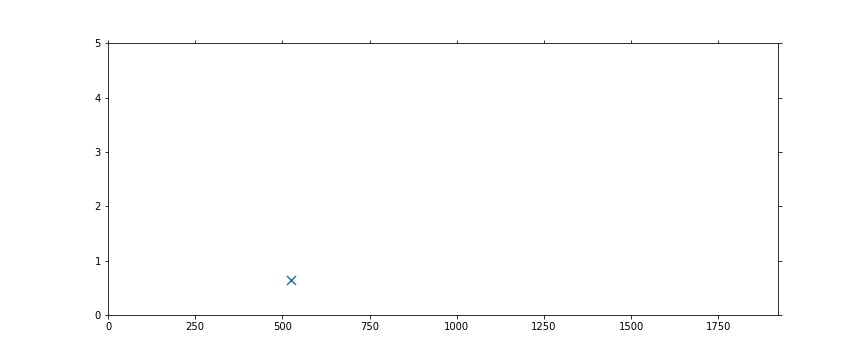

In [19]:
fig, axe = plt.subplots(figsize=(12, 5))

def animate(frameId):
            
    axe.clear()
    axe.set_xlim(0, 1920)
    axe.set_ylim(0, 5)
    
    img, depthmap, flowmap, tboxes, bboxes = sequence[frameId]
    positions = []
    for box in bboxes:
        xmin = box[1]
        ymin = box[2]
        xmax = box[1] + box[3]
        ymax = box[2] + box[4]
        # Raw depth distribution
        depth_dist = depthmap[TARGET, int(ymin):int(ymax), int(xmin+xmax)//2]
        depth_dist = depth_dist.numpy().reshape(-1)
        # Median filtered depth distribution along y axis
        means, depth = sample_mean(depth_dist, rounds=300)
#         depth = np.median(depth_dist)
        x, y, z = (xmin+xmax)/2, (ymin+ymax)/2, (1-depth)*5
        positions.append((x, y, z))
        
    positions = np.array(positions)
    if len(positions) > 0:
        axe.scatter(positions[:, 0], positions[:, 2], s=80, marker='x')

ani = FuncAnimation(fig, animate, frames=len(sequence), interval=40)
plt.show()